# Import dependencies

In [1]:
# import the necessary packages
import itertools
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
# !pip install pykitti
import pykitti
import cv2
from matplotlib.patches import Circle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from matplotlib.cm import get_cmap
from matplotlib.patches import Circle, Arrow
import time
import os
import copy
# !pip install pytorchvis
# !pip install torchsummary
from torchsummary import summary
from pytorchvis.visualize_layers import VisualizeLayers
from PIL import Image as PImage
import io
import math
from scipy.spatial import distance as dist

plt.ion()   # interactive mode

# Load Kitti dataset

In [2]:
# Path to KITTI directory
basedir = '.../2011_09_26_drive_0002_sync/'
date = '2011_09_26'
drive = '0002'

dataset = pykitti.raw(basedir, date, drive)

## Get camera displacement

In [3]:

def latToScale(lat):
# compute mercator scale from latitude
    return math.cos(lat * math.pi / 180)

def latlonToMercator(lat,lon,scale):
# converts lat/lon coordinates to mercator coordinates using mercator scale
    er = 6378137 # earth radius
    mx = scale * lon * math.pi * er / 180
    my = scale * er * math.log( math.tan((90+lat) * math.pi / 360) )
    return mx, my

def convertOxtsToPose(oxts):
    scale = latToScale(oxts[0][0])
    pose = []
    Tr_0_inv = np.zeros(shape=(4,4))
    Tr = np.zeros(shape=(4,4))
    t = np.zeros(shape=(3, 1))
    for i in range(len(oxts)):
        if not oxts[i]:
            pose.append([])
            continue

        # translation vector 
        t[0,0], t[1,0] = latlonToMercator(oxts[i][0],oxts[i][1],scale)
        t[2,0] = oxts[i][2]

        # rotation matrix (OXTS RT3000 user manual, page 71/92)
        rx = oxts[i][3] # roll
        ry = oxts[i][4] # pitch
        rz = oxts[i][5] # heading 
        # base => nav  (level oxts => rotated oxts)
        Rx = np.matrix([[1, 0, 0], [0, math.cos(rx), -math.sin(rx)], [0, math.sin(rx), math.cos(rx)]]) 
        # base => nav  (level oxts => rotated oxts)
        Ry =  np.matrix([[math.cos(ry), 0, math.sin(ry)], [0, 1, 0], [-math.sin(ry), 0, math.cos(ry)]]) 
        # base => nav  (level oxts => rotated oxts)
        Rz = np.matrix([[math.cos(rz), -math.sin(rz), 0], [math.sin(rz), math.cos(rz), 0], [0, 0, 1]]) 
        R  = Rz*Ry*Rx

        # print(R)
        # print(t)
        Tr[:3, :3] = R
        Tr[:3, 3:] = t
        Tr[3,3] = 1
        # normalize translation and rotation (start at 0/0/0)
        if i == 0:
            Tr_0_inv = np.linalg.inv(Tr)

        pose.append((Tr_0_inv.dot(Tr)))
    return np.stack(pose)


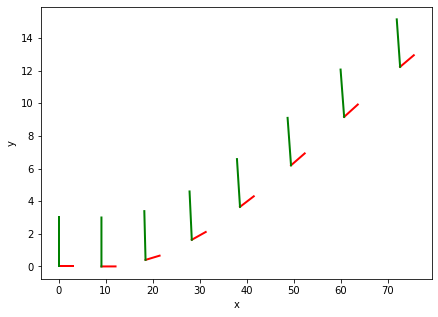

In [4]:
fig,ax = plt.subplots(1, figsize=(7,5))
# ax = plt.axes(projection='3d')

oxts = []
for pos in dataset.oxts:
    oxt = [i for i in pos[0]]
    oxts.append(oxt)

camera_displacement = []
pose = convertOxtsToPose(oxts)
l = 3 # coordinate axis length
A = np.array([[0, 0, 0, 1], [l, 0, 0, 1], [0, 0, 0, 1], [0, l, 0, 1], [0, 0, 0, 1], [0, 0, l, 1]]).transpose()
for i in range(0, len(pose), 10):
    B = pose[i].dot(A)
    ax.plot(B[0,0:2],B[1,0:2],color='red',linewidth=2) # x: red
    ax.plot(B[0,2:4],B[1,2:4],color='green',linewidth=2) # y: green
    # ax.plot(B[0,4:6],B[1,4:6],B[2,4:6],color='blue',linewidth=2) # z: blue
    if i > 0:
        coord= []
        coord.append(B[0,0:2][0] - pose[i-10].dot(A)[0,0:2][0]) # x displacement where positive is forwards
        coord.append(B[1,2:4][0] - pose[i-10].dot(A)[1,2:4][0]) # x displacement where positive is left turn
        camera_displacement.append(coord)
ax.set_xlabel('x')
ax.set_ylabel('y')
# ax.set_zlabel('z')
plt.show()

## Display Velodyne depth points in the image

In [5]:
# https://stackoverflow.com/questions/45333780/kitti-velodyne-point-to-pixel-coordinate
def prepare_velo_points(pts3d_raw):
    '''Replaces the reflectance value by 1, and tranposes the array, so
       points can be directly multiplied by the camera projection matrix'''

    pts3d = pts3d_raw
    # Reflectance > 0
    pts3d = pts3d[pts3d[:, 3] > 0 ,:]
    pts3d[:,3] = 1
    return pts3d.transpose()

def project_velo_points_in_img(pts3d, T_cam_velo, Rrect, Prect):
    '''Project 3D points into 2D image. Expects pts3d as a 4xN
       numpy array. Returns the 2D projection of the points that
       are in front of the camera only an the corresponding 3D points.'''

    # 3D points in camera reference frame.
    pts3d_cam = Rrect.dot(T_cam_velo.dot(pts3d))

    # Before projecting, keep only points with z>0 
    # (points that are in fronto of the camera).
    idx = (pts3d_cam[2,:]>=0)
    pts2d_cam = Prect.dot(pts3d_cam[:,idx])
    return pts3d[:, idx], pts2d_cam/pts2d_cam[2,:]

In [6]:
pts3d = prepare_velo_points(dataset.get_velo(0))
projectionX = project_velo_points_in_img(pts3d, dataset.calib.T_cam3_velo, dataset.calib.R_rect_30
,dataset.calib.P_rect_30)

pts3d = prepare_velo_points(dataset.get_velo(1))
projectionY = project_velo_points_in_img(pts3d, dataset.calib.T_cam3_velo, dataset.calib.R_rect_30
,dataset.calib.P_rect_30)

pts3d = prepare_velo_points(dataset.get_velo(2))
projectionZ = project_velo_points_in_img(pts3d, dataset.calib.T_cam3_velo, dataset.calib.R_rect_30
,dataset.calib.P_rect_30)

<function matplotlib.pyplot.show(*args, **kw)>

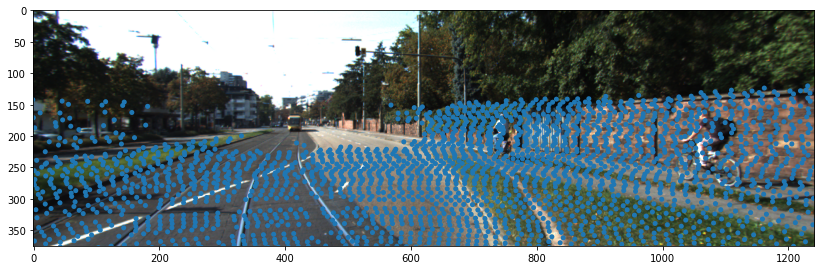

In [7]:
first_cam3 = dataset.get_cam3(0)
fig,ax = plt.subplots(1, figsize=(14,14))
ax.set_aspect('equal')
ax.imshow(first_cam3)
ctr = 0
for src_x, src_y in zip(projectionX[1][0], projectionX[1][1]):
    ctr +=1
    if ctr == 7:
        circ_src = Circle((src_x,src_y), 4)
        ax.add_patch(circ_src)
        ctr = 0
plt.show

# Convolutional features

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg16(pretrained=True).to(device)

In [9]:
# Path to the KITTI sequence frames
IX_path = '../Images/0000000000.jpg'
IY_path = '../Images/0000000001.jpg'
IZ_path = '../Images/0000000002.jpg'

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize([224, 224]),
   transforms.ToTensor(),
   normalize
])
shape = np.array([224.0, 224.0])
IX = plt.imread(IX_path)
IY = plt.imread(IY_path)
IZ = plt.imread(IZ_path)

# used to reshape features to original image
scale = 1.0 * np.array(IX.shape[:2]) / shape

IX_trand = preprocess(PImage.fromarray(IX))
IX_trand.unsqueeze_(0)

IY_trand = preprocess(PImage.fromarray(IY))
IY_trand.unsqueeze_(0)

IZ_trand = preprocess(PImage.fromarray(IZ))
IZ_trand.unsqueeze_(0)

cnn_input = torch.cat((IX_trand, IY_trand, IZ_trand), dim=0)

In [10]:
def pairwise_distance(X, Y):
    assert len(X.shape) == len(Y.shape)
    N = X.shape[0]
    M = Y.shape[0]
    # D = len(X.shape)
    res = np.zeros([M, N])
    for i in range(M):
        for j in range(N):
            res[i][j] = np.linalg.norm(X[j] - Y[i])
    return res

def match(PD):
    seq = np.arange(PD.shape[0]) # create array of a certain shape from 0 to len
    amin1 = np.argmin(PD, axis=1) # return smallest index from each list
    C = np.array([seq, amin1]).transpose()
    min1 = PD[seq, amin1] # array of the minimum distances
    mask = np.zeros_like(PD) # return an array of zeros of the same shape as DP
    mask[seq, amin1] = 1
    masked = np.ma.masked_array(PD, mask) # PD without the smallest values
    min2 = np.amin(masked, axis=1) # return smallest num in list
    return C, np.array(min2/min1)

def match_max(PD):
    seq = np.arange(PD.shape[0])
    amax1 = np.argmin(PD, axis=1)
    C = np.array([seq, amax1]).transpose()
    return C

In [11]:
# create an object of VisualizeLayers and initialize it with the model and 
# the layers whose output you want to visualize
vis = VisualizeLayers(model,layers='all')
# pass the input and get the output
output = model(cnn_input.to(device))
# get the intermediate layers output which was passed d  uring initialization
interm_output = vis.get_interm_output()
features_pool3 = interm_output['features.16_pooling_MaxPool2d'].cpu()
# features_pool4 = interm_output['features.23_pooling_MaxPool2d'].cpu()
# features_pool5 = interm_output['features.30_pooling_MaxPool2d'].cpu()


featureMap = []
DY1 = np.zeros(shape=(784,256))
pool3_flat = np.reshape(features_pool3[1], [-1, 784]).numpy()
for i in range(pool3_flat.shape[1]):
    for kernel in pool3_flat:
        featureMap.append(kernel[i])
    DY1[i] = featureMap
    featureMap = []

DX1 = np.zeros(shape=(784,256))
pool3_flat = np.reshape(features_pool3[0], [-1, 784]).numpy()
for i in range(pool3_flat.shape[1]):
    for kernel in pool3_flat:
        featureMap.append(kernel[i])
    DX1[i] = featureMap
    featureMap = []

DZ1 = np.zeros(shape=(784,256))
pool3_flat = np.reshape(features_pool3[2], [-1, 784]).numpy()
for i in range(pool3_flat.shape[1]):
    for kernel in pool3_flat:
        featureMap.append(kernel[i])
    DZ1[i] = featureMap
    featureMap = []

# First pair of images
PD1 = pairwise_distance(DX1, DY1)
# Second pair of images
PD2 = pairwise_distance(DY1, DZ1)

features_container_Sequential
	 features.0_conv_Conv2d
	 features.1_activation_ReLU
	 features.2_conv_Conv2d
	 features.3_activation_ReLU
	 features.4_pooling_MaxPool2d
	 features.5_conv_Conv2d
	 features.6_activation_ReLU
	 features.7_conv_Conv2d
	 features.8_activation_ReLU
	 features.9_pooling_MaxPool2d
	 features.10_conv_Conv2d
	 features.11_activation_ReLU
	 features.12_conv_Conv2d
	 features.13_activation_ReLU
	 features.14_conv_Conv2d
	 features.15_activation_ReLU
	 features.16_pooling_MaxPool2d
	 features.17_conv_Conv2d
	 features.18_activation_ReLU
	 features.19_conv_Conv2d
	 features.20_activation_ReLU
	 features.21_conv_Conv2d
	 features.22_activation_ReLU
	 features.23_pooling_MaxPool2d
	 features.24_conv_Conv2d
	 features.25_activation_ReLU
	 features.26_conv_Conv2d
	 features.27_activation_ReLU
	 features.28_conv_Conv2d
	 features.29_activation_ReLU
	 features.30_pooling_MaxPool2d
avgpool_pooling_AdaptiveAvgPool2d
classifier_container_Sequential
	 classifier.0_linear_Line

In [12]:
seq = np.array([[i, j] for i in range(28)
                for j in range(28)], dtype='int32')

X = np.array(seq, dtype='float32') * 8.0 + 4.0
Y1 = np.array(seq, dtype='float32') * 8.0 + 4.0
Y2 = np.array(seq, dtype='float32') * 8.0 + 4.0
Z = np.array(seq, dtype='float32') * 8.0 + 4.0

# normalize
X = X/ 224.0
Y1 = Y1/ 224.0
Y2 = Y2/ 224.0
Z = Z/ 224.0

# prematch and select points first pair
C_all, quality = match(PD1)
theta_max = np.max(quality) # large starting threshold that only confident inliers satisfy

# Don't stop until threshold allows at least 128 distances.
# Automatic threshold to select the most reliable 128 distances (high quality ratio)
# A large number of features points are selected using low threshold to filter out irrelevant points.
while np.where(quality >= theta_max)[0].shape[0] <= 50:
    theta_max -= 0.01

# tell me where in quality, entries are >= theta_max
C = C_all[np.where(quality >= theta_max)] 

cnt = C.shape[0] # number of features with > theta_max 155

# select prematched feature points
X, Y1 = X[C[:, 1]], Y1[C[:, 0]]


C_all, quality = match(PD2)
theta_max = np.max(quality)
while np.where(quality >= theta_max)[0].shape[0] <= 50:
    theta_max -= 0.01
C = C_all[np.where(quality >= theta_max)] 
Y2, Z = Y2[C[:, 1]], Z[C[:, 0]]


## Select features with depth information

In [13]:
Xscaled = (X*224.0)*scale
Y1scaled = (Y1*224.0)*scale
Y2scaled = (Y2*224.0)*scale
Zscaled = (Z*224.0)*scale

featureWithDepthX = np.zeros(shape=(Xscaled.shape[0], Xscaled.shape[1] +2), dtype=np.float64)
featureWithDepthY1 = np.zeros(shape=(Y1scaled.shape[0], Y1scaled.shape[1] +2), dtype=np.float64)
featureWithDepthY2 = np.zeros(shape=(Y2scaled.shape[0], Y2scaled.shape[1] +2), dtype=np.float64)
featureWithDepthZ = np.zeros(shape=(Zscaled.shape[0], Zscaled.shape[1] +2), dtype=np.float64)

projectionX_roundedX = [round(i, 1) for i in projectionX[1][0]]
projectionX_roundedY = [round(i, 1) for i in projectionX[1][1]]
projectionY_roundedX = [round(i, 1) for i in projectionY[1][0]]
projectionY_roundedY = [round(i, 1) for i in projectionY[1][1]]
projectionZ_roundedX = [round(i, 1) for i in projectionZ[1][0]]
projectionZ_roundedY = [round(i, 1) for i in projectionZ[1][1]]

In [14]:
def find2perCent(num, listPro):
    listfeatures = []
    Menys = 0.98 * num
    Mes = 1.02 * num 
    for i, el in enumerate(listPro):
        if el < Mes and el > Menys:
            listfeatures.append(i)
    return listfeatures

In [15]:
for i, feature in enumerate(Xscaled):
    listindX =find2perCent(round(feature[1], 1), projectionX_roundedX)
    listindY =find2perCent(round(feature[0], 1), projectionX_roundedY)
    if len(listindY) > 0 and len(listindX) > 0:
        cand = set(listindX).intersection(listindY) # detect coordindates 
        if len(cand)>0:
            featureWithDepthX[i] = np.append(feature, [True, projectionX[0][0][cand.pop()]])


for i, feature in enumerate(Y1scaled):
    listindX =find2perCent(round(feature[1], 1), projectionY_roundedX)
    listindY =find2perCent(round(feature[0], 1), projectionY_roundedY)
    if len(listindY) > 0 and len(listindX) > 0:
        cand = set(listindX).intersection(listindY) # detect coordindates 
        if len(cand)>0:
            featureWithDepthY1[i] = np.append(feature, [True, projectionY[0][0][cand.pop()]])

for i, feature in enumerate(Y2scaled):
    listindX =find2perCent(round(feature[1], 1), projectionY_roundedX)
    listindY =find2perCent(round(feature[0], 1), projectionY_roundedY)
    if len(listindY) > 0 and len(listindX) > 0:
        cand = set(listindX).intersection(listindY) # detect coordindates 
        if len(cand)>0:
            featureWithDepthY2[i] = np.append(feature, [True, projectionY[0][0][cand.pop()]])
        
for i, feature in enumerate(Zscaled):
    listindX =find2perCent(round(feature[1], 1), projectionZ_roundedX)
    listindY =find2perCent(round(feature[0], 1), projectionZ_roundedY)
    if len(listindY) > 0 and len(listindX) > 0:
        cand = set(listindX).intersection(listindY) # detect coordindates 
        if len(cand)>0:
            featureWithDepthZ[i] = np.append(feature, [True, projectionZ[0][0][cand.pop()]])

# Display matches with depth information

Number of features: 52
Number of drawn features 1: 23
Number of drawn features 2: 39


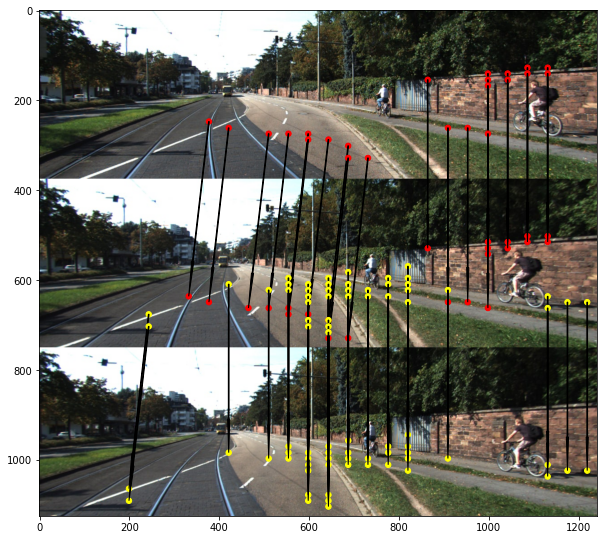

In [25]:
res = np.zeros(shape=(IX.shape[0]+ IY.shape[0]+ IZ.shape[0], IX.shape[1], 3), dtype=np.uint8)
res[:IX.shape[0], :, :] = IX
res[IX.shape[0]:IX.shape[0]+IX.shape[0], :, :] = IY
res[IX.shape[0]+IX.shape[0]:, :, :] = IZ


fig,ax = plt.subplots(1, figsize=(10,10))
ax.set_aspect('equal')
ax.imshow(res)
print(f"Number of features: {Xscaled.shape[0]}")
cmap = get_cmap("hsv")
featuresDepthMatch_ctr = 0
for i, pnt in enumerate(featureWithDepthX):
    if pnt[2] == True and featureWithDepthY1[i][2] == True:
        featuresDepthMatch_ctr +=1
        src_x1 = int(pnt[1])
        src_y1 = int(pnt[0])
        dst_x1 = int(featureWithDepthY1[i][1])
        dst_y1 = int(featureWithDepthY1[i][0] + IX.shape[0])

        # First pair
        circ_src = Circle((src_x1,src_y1), 6, color="red")
        ax.add_patch(circ_src)
        # ax.annotate(featuresDepthMatch_ctr, (src_x1, src_y1))
        circ_dst = Circle((dst_x1,dst_y1), 6, color="red")
        ax.add_patch(circ_dst)
        # ax.annotate(featuresDepthMatch_ctr, (dst_x1, dst_y1))
        line = Arrow(src_x1, src_y1, dst_x1-src_x1, dst_y1-src_y1, 8, color= "black")
        ax.add_patch(line)

print(f"Number of drawn features 1: {featuresDepthMatch_ctr}")
featuresDepthMatch_ctr = 0
for i, pnt in enumerate(featureWithDepthY2):
    if pnt[2] == True and featureWithDepthZ[i][2] == True:
        featuresDepthMatch_ctr +=1
        src_x2 = int(featureWithDepthY2[i][1])
        src_y2 = int(featureWithDepthY2[i][0] + IX.shape[0])
        dst_x2 = int(featureWithDepthZ[i][1])
        dst_y2 = int(featureWithDepthZ[i][0] + IX.shape[0]+IX.shape[0])

        # Second pair
        circ_src = Circle((src_x2,src_y2), 6, color="yellow")
        ax.add_patch(circ_src)
        # ax.annotate(featuresDepthMatch_ctr, (src_x2, src_y2))
        circ_dst = Circle((dst_x2,dst_y2), 6, color="yellow")
        ax.add_patch(circ_dst)
        # ax.annotate(featuresDepthMatch_ctr, (dst_x2, dst_y2))
        line = Arrow(src_x2, src_y2, dst_x2-src_x2, dst_y2-src_y2, 8, color= "black")
        ax.add_patch(line)

print(f"Number of drawn features 2: {featuresDepthMatch_ctr}")
plt.show()

In [31]:
difference_listX = []
difference_listY = []
difference_listZ = []
euclideanDistance_list = []

coordinatesSRC = []
coordinatesDST = []
depthListSRC = []
depthListDST = []

for i, pnt in enumerate(featureWithDepthX):
    if pnt[2] == True and featureWithDepthY1[i][2] == True:
        src_x = (pnt[1])
        src_y = (pnt[0])
        dst_x = (featureWithDepthY1[i][1])
        dst_y = (featureWithDepthY1[i][0])

        difference_listX.append(src_x - dst_x)
        difference_listY.append(src_y - dst_y)
        difference_listZ.append(featureWithDepthX[i][3] - featureWithDepthY1[i][3])
        euclideanDistance_list.append(dist.euclidean((src_x, src_y), (dst_x, dst_y)))
        
        coordinatesSRC.append(src_x/IY.shape[1])
        coordinatesSRC.append(src_y/IY.shape[0])
        depthListSRC.append(featureWithDepthX[i][3])

        coordinatesDST.append(dst_x/IY.shape[1])
        coordinatesDST.append(dst_y/IY.shape[0])
        depthListDST.append(featureWithDepthY1[i][3])